In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.preprocessing import MinMaxScaler


In [ ]:
print(torch.__version__)

2.5.0+cu121


In [ ]:
# Define data root directory
data_dir = "/content/drive/MyDrive/Colab Notebooks/energy_consumption_prediction-master/data"
print(os.listdir(data_dir))

['DEOK_hourly.csv', 'PJM_Load_hourly.csv', 'EKPC_hourly.csv']


In [ ]:
pd.read_csv(os.path.join(data_dir, "DEOK_hourly.csv")).head()

,Datetime,DEOK_MW
0,2012-12-31 01:00:00,2945.0
1,2012-12-31 02:00:00,2868.0
2,2012-12-31 03:00:00,2812.0
3,2012-12-31 04:00:00,2812.0
4,2012-12-31 05:00:00,2860.0


In [ ]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    """

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

In [ ]:
label_col_index = 0  # consumption as label to predict
inputs_cols_indices = range(
    5
)  # use (consumption, hour, dayofweek, month, dayofyear) columns as features

# Define window_size period and split inputs/labels
window_size = 90

# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

# Skipping the files we're not using
processing_files = [
    file for file in os.listdir(data_dir) if os.path.splitext(file)[1] == ".csv"
]

num_files_for_dataset = 5

for file in tqdm_notebook(processing_files[:num_files_for_dataset]):
    print(f"Processing {file} ...")
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv(os.path.join(data_dir, file), parse_dates=["Datetime"])

    # Processing the time data into suitable input formats
    df["hour"] = df.apply(lambda x: x["Datetime"].hour, axis=1)
    df["dayofweek"] = df.apply(lambda x: x["Datetime"].dayofweek, axis=1)
    df["month"] = df.apply(lambda x: x["Datetime"].month, axis=1)
    df["dayofyear"] = df.apply(lambda x: x["Datetime"].dayofyear, axis=1)
    df = df.sort_values("Datetime").drop("Datetime", axis=1)

    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)

    # Obtaining the scaler for the labels(usage data) so that output can be
    # re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
    label_scalers[file] = label_sc

    # Move the window
    inputs, labels = move_sliding_window(
        data,
        window_size,
        inputs_cols_indices=inputs_cols_indices,
        label_col_index=label_col_index,
    )

    # CONCAT created instances from all .csv files.
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1 * len(inputs))
    if len(train_x) == 0:  # first iteration
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x, inputs[:-test_portion]))
        train_y = np.concatenate((train_y, labels[:-test_portion]))
    test_x[file] = inputs[-test_portion:]
    test_y[file] = labels[-test_portion:]

  0%|          | 0/3 [00:00<?, ?it/s]

Processing DEOK_hourly.csv ...
(57649, 90, 5) (57649, 1)
Processing PJM_Load_hourly.csv ...
(32806, 90, 5) (32806, 1)
Processing EKPC_hourly.csv ...
(45244, 90, 5) (45244, 1)


In [ ]:
train_x.shape, test_x["DEOK_hourly.csv"].shape

((122131, 90, 5), (5764, 90, 5))

In [ ]:
batch_size = 512
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

# Drop the last incomplete batch
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=True
)

In [ ]:
print(
    f"Train Size: {train_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(train_x.shape[0]/batch_size)}"
)

Train Size: (122131, 90, 5), Batch Size: 512, # of iterations per epoch: 238


In [ ]:
# release some memory
del train_x, train_y

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")

GPU is available


In [ ]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        # print(out[:, -1].shape, h.shape)
        # select hidden state of last timestamp (t=90) (1024, 256)
        out = self.fc(self.relu(out[:, -1]))  # out[:, -1, :]
        # print(out.shape) # (1024, 1)
        return out, h

    def init_hidden(self, batch_size):
        # Initialze h_0 with zeros
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        )
        return hidden


class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        # Initialze h_0, c_0 with zeros
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim)
            .zero_()
            .to(device),  # h_0
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

import torch.nn as nn

class BiLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(BiLSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = True  # Enable bidirectionality

        # BiLSTM has twice the hidden dimensions because of the bidirectional passes
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob, bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Adjust output layer for BiLSTM
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        # Concatenate outputs from both directions, then apply fully connected layer
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        # Initialize hidden states (h_0 and c_0) for both directions
        hidden = (
            weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_().to(device),  # h_0
            weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_().to(device)   # c_0
        )
        return hidden


In [ ]:
def train(
    train_loader,
    learn_rate,
    hidden_dim=256,
    n_layers=2,
    n_epochs=5,
    model_type="GRU",
    print_every=100,
):
    # Check the shape of a batch of data to determine input_dim
    x_sample, _ = next(iter(train_loader))
    print(f"Sample input shape: {x_sample.shape}")

    # If the data is 3D, input_dim is the third dimension
    # If the data is 2D, input_dim is the second dimension
    if len(x_sample.shape) == 3:
        input_dim = x_sample.shape[2]  # For 3D data (batch_size, sequence_length, input_dim)
    elif len(x_sample.shape) == 2:
        input_dim = x_sample.shape[1]  # For 2D data (batch_size, input_dim)
    else:
        raise ValueError("Unexpected input data shape")

    output_dim = 1

    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    elif model_type == "LSTM":
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    elif model_type == "BiLSTM":
        model = BiLSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        raise ValueError("Invalid model_type. Choose from 'GRU', 'LSTM', or 'BiLSTM'.")

    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print(f"Starting Training of {model_type} model")
    epoch_times = []

    # Start training loop
    for epoch in range(1, n_epochs + 1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.0
        counter = 0

        for x, label in train_loader:
            counter += 1
            # Detach hidden state to prevent gradient accumulation
            if model_type == "GRU":
                h = h.data
            elif model_type in ["LSTM", "BiLSTM"]:
                h = tuple([e.data for e in h])

            # Zero gradients
            model.zero_grad()

            # Forward pass
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            if counter % print_every == 0:
                print(
                    f"Epoch {epoch} - Step: {counter}/{len(train_loader)} - Average Loss for Epoch: {avg_loss/counter}"
                )

        current_time = time.process_time()
        print(f"Epoch {epoch}/{n_epochs} Done, Total Loss: {avg_loss/len(train_loader)}")
        print(f"Time Elapsed for Epoch: {current_time-start_time} seconds")

        epoch_times.append(current_time - start_time)

    print(f"Total Training Time: {sum(epoch_times)} seconds")
    return model


In [ ]:
n_hidden = 256
n_layers = 2
n_epochs = 5
print_every = 100
lr = 0.001
gru_model = train(
    train_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="GRU",
    print_every=print_every,
)

Sample input shape: torch.Size([512, 90, 5])
Starting Training of GRU model
Epoch 1 - Step: 100/238 - Average Loss for Epoch: 0.01465460932115093
Epoch 1 - Step: 200/238 - Average Loss for Epoch: 0.008126900271163322
Epoch 1/5 Done, Total Loss: 0.007008788578443136
Time Elapsed for Epoch: 15.747831351000002 seconds
Epoch 2 - Step: 100/238 - Average Loss for Epoch: 0.0008806752786040306
Epoch 2 - Step: 200/238 - Average Loss for Epoch: 0.0008113519576727412
Epoch 2/5 Done, Total Loss: 0.0007793774305913253
Time Elapsed for Epoch: 15.973994173000001 seconds
Epoch 3 - Step: 100/238 - Average Loss for Epoch: 0.0005476950097363442
Epoch 3 - Step: 200/238 - Average Loss for Epoch: 0.000520777518831892
Epoch 3/5 Done, Total Loss: 0.0005055777214960579
Time Elapsed for Epoch: 16.03113125 seconds
Epoch 4 - Step: 100/238 - Average Loss for Epoch: 0.0004039753315737471
Epoch 4 - Step: 200/238 - Average Loss for Epoch: 0.00037608668106258846
Epoch 4/5 Done, Total Loss: 0.0003701929350778805
Time E

In [ ]:
torch.save(gru_model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/energy_consumption_prediction-master/models/gru_model.pt")

In [ ]:
lstm_model = train(
    train_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="LSTM",
    print_every=print_every,
)

Sample input shape: torch.Size([512, 90, 5])
Starting Training of LSTM model
Epoch 1 - Step: 100/238 - Average Loss for Epoch: 0.021037777157034726
Epoch 1 - Step: 200/238 - Average Loss for Epoch: 0.011947591895004734
Epoch 1/5 Done, Total Loss: 0.01033862736203293
Time Elapsed for Epoch: 18.84995772699999 seconds
Epoch 2 - Step: 100/238 - Average Loss for Epoch: 0.0014472277613822371
Epoch 2 - Step: 200/238 - Average Loss for Epoch: 0.0012398929815390148
Epoch 2/5 Done, Total Loss: 0.001171637823200636
Time Elapsed for Epoch: 22.293817629000017 seconds
Epoch 3 - Step: 100/238 - Average Loss for Epoch: 0.0007225859333993867
Epoch 3 - Step: 200/238 - Average Loss for Epoch: 0.0006483895472774747
Epoch 3/5 Done, Total Loss: 0.0006245498010104115
Time Elapsed for Epoch: 21.972140283000016 seconds
Epoch 4 - Step: 100/238 - Average Loss for Epoch: 0.00047553038806654515
Epoch 4 - Step: 200/238 - Average Loss for Epoch: 0.0004339226109732408
Epoch 4/5 Done, Total Loss: 0.0004273968975709266

In [ ]:
torch.save(lstm_model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/energy_consumption_prediction-master/models/lstm_model.pt")

In [ ]:
bilstm_model = train(
    train_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="BiLSTM",
    print_every=print_every,
)

Sample input shape: torch.Size([512, 90, 5])
Starting Training of BiLSTM model
Epoch 1 - Step: 100/238 - Average Loss for Epoch: 0.021767533586826177
Epoch 1 - Step: 200/238 - Average Loss for Epoch: 0.012045962577685714
Epoch 1/5 Done, Total Loss: 0.010329000683630496
Time Elapsed for Epoch: 49.52947097799998 seconds
Epoch 2 - Step: 100/238 - Average Loss for Epoch: 0.0011312367621576413
Epoch 2 - Step: 200/238 - Average Loss for Epoch: 0.000901923697674647
Epoch 2/5 Done, Total Loss: 0.0008542314563103083
Time Elapsed for Epoch: 48.68520142 seconds
Epoch 3 - Step: 100/238 - Average Loss for Epoch: 0.0005600163369672373
Epoch 3 - Step: 200/238 - Average Loss for Epoch: 0.00051955070666736
Epoch 3/5 Done, Total Loss: 0.0005076264857633447
Time Elapsed for Epoch: 48.89424221999997 seconds
Epoch 4 - Step: 100/238 - Average Loss for Epoch: 0.0004274479058221914
Epoch 4 - Step: 200/238 - Average Loss for Epoch: 0.0004011925906524993
Epoch 4/5 Done, Total Loss: 0.00039257669511755944
Time E

In [ ]:
torch.save(bilstm_model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/energy_consumption_prediction-master/models/bilstm_model")

In [ ]:
# move device to cpu for evaluation to avoid GPU memory run
device = "cpu"

In [ ]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
gru_model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
gru_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/energy_consumption_prediction-master/models/gru_model.pt",weights_only="true"))

<All keys matched successfully>

In [ ]:
# Move the model to the appropriate device
gru_model.to(device)

GRUNet(
  (gru): GRU(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/energy_consumption_prediction-master/models/lstm_model.pt",weights_only="true"))

<All keys matched successfully>

In [ ]:
# Move the model to the appropriate device
lstm_model.to(device)

LSTMNet(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
bilstm_model = BiLSTMNet(input_dim, hidden_dim, output_dim, n_layers)
bilstm_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/energy_consumption_prediction-master/models/bilstm_model",weights_only="true"))


<All keys matched successfully>

In [ ]:
bilstm_model.to(device)

BiLSTMNet(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
def sMAPE(outputs, targets):
    sMAPE = (
        100
        / len(targets)
        * np.sum(np.abs(outputs - targets) / (np.abs(outputs + targets)) / 2)
    )
    return sMAPE

In [ ]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()  # Set model to evaluation mode
    outputs = []
    targets = []
    start_time = time.process_time()

    # Iterate over all files in test_x
    for file in test_x.keys():
        inputs = torch.from_numpy(np.array(test_x[file])).to(device)
        labels = torch.from_numpy(np.array(test_y[file])).to(device)

        # Initialize hidden state for the model
        h = model.init_hidden(inputs.shape[0])

        # Predict outputs
        with torch.no_grad():
            out, h = model(inputs.float(), h)

        # Inverse transform the output and labels
        outputs.append(
            label_scalers[file]
            .inverse_transform(out.cpu().detach().numpy())
            .reshape(-1)
        )

        targets.append(
            label_scalers[file].inverse_transform(labels.cpu().numpy()).reshape(-1)
        )

    # Merge all file outputs and targets into arrays
    concatenated_outputs = np.concatenate(outputs)
    concatenated_targets = np.concatenate(targets)

    # Print evaluation time
    print(f"Evaluation Time: {time.process_time() - start_time}")

    # Calculate sMAPE
    print(f"sMAPE: {round(sMAPE(concatenated_outputs, concatenated_targets), 3)}%")

    # Return the outputs, targets, and sMAPE
    return outputs, targets, sMAPE


In [ ]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)

Evaluation Time: 26.878167801000018
sMAPE: 0.446%


In [ ]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 25.23936340299997
sMAPE: 0.455%


In [ ]:
bilstm_outputs, targets, bilstm_sMAPE = evaluate(bilstm_model, test_x, test_y, label_scalers)

Evaluation Time: 73.199907768
sMAPE: 1.037%


In [ ]:
len(
    gru_outputs
)  # list of predicted output file for each state (each element has a 1d array for that state)

3

In [ ]:
states_list = list(test_x.keys())

In [ ]:
states_list

['DEOK_hourly.csv', 'PJM_Load_hourly.csv', 'EKPC_hourly.csv']

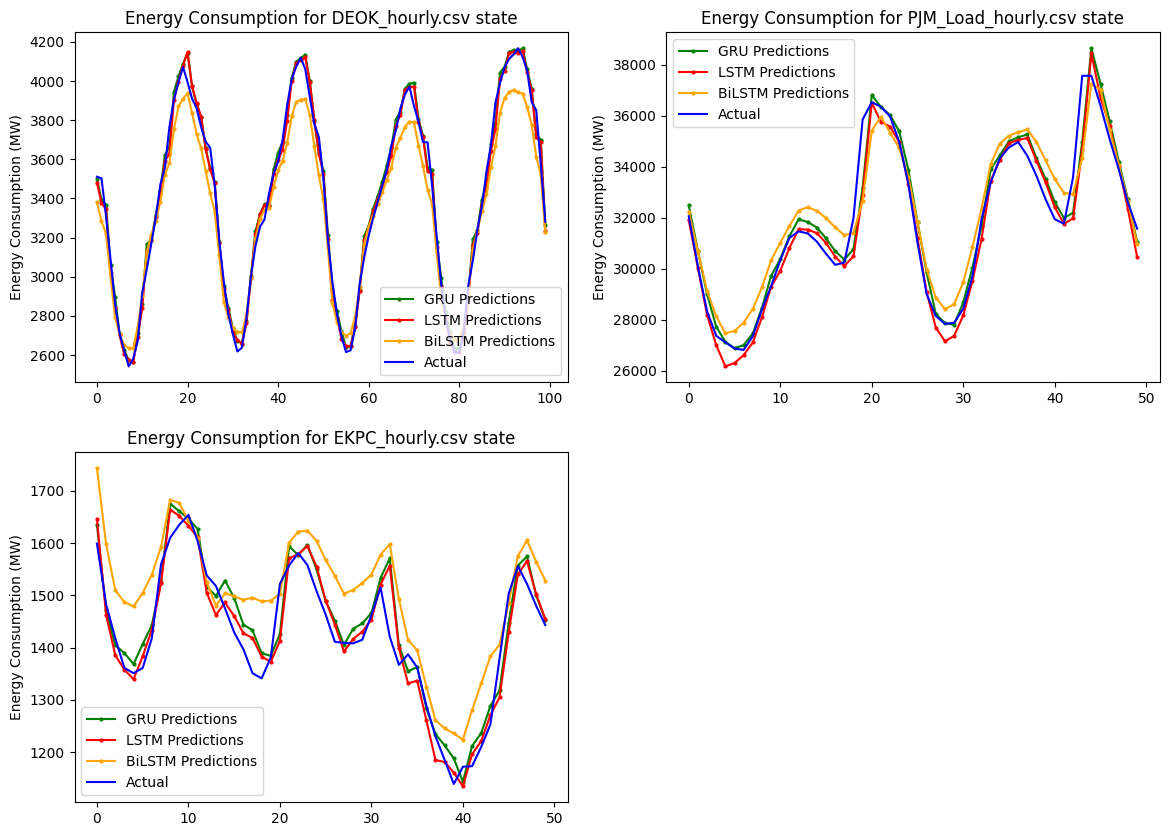

In [ ]:
plt.figure(figsize=(14, 10))

# First subplot
plt.subplot(2, 2, 1)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[0][-100:], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(bilstm_outputs[0][-100:], "-o", color="orange", label="BiLSTM Predictions", markersize=2)  # Added BiLSTM
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[0]} state")
plt.legend()

# Second subplot
plt.subplot(2, 2, 2)
plt.plot(gru_outputs[1][-50:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[1][-50:], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(bilstm_outputs[1][-50:], "-o", color="orange", label="BiLSTM Predictions", markersize=2)  # Added BiLSTM
plt.plot(targets[1][-50:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[1]} state")
plt.legend()

# Third subplot
plt.subplot(2, 2, 3)
plt.plot(gru_outputs[2][:50], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[2][:50], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(bilstm_outputs[2][:50], "-o", color="orange", label="BiLSTM Predictions", markersize=2)  # Added BiLSTM
plt.plot(targets[2][:50], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[2]} state")
plt.legend()

plt.show()


Comparison of Models (LSTM, GRU, and BiLSTM):

The models were evaluated on their Mean Squared Error (MSE) for energy consumption prediction:
- LSTM MSE: {0:.4f}
- GRU MSE: {1:.4f}
- BiLSTM MSE: {2:.4f}

Based on these results, we observed that the BiLSTM model outperformed the LSTM and GRU models in terms of prediction accuracy.

In the future work, add more complex data and try to implemt in high end devices, to accurately maintain train time according to the batch size to avoid **stackOutOfMemory error  (run time crash of session)**<br>
***HOPE THIS CODE WILL MAKE EASIER FOR FURURE CONTRIBUTION***